In [481]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [482]:
with open('names.txt') as f:
    words = f.read().splitlines()

In [483]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [484]:
len(words)

32033

In [485]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

In [486]:
SPECIAL_CHAR = '.'
chars =  [SPECIAL_CHAR] + sorted(list(set(''.join(words))))
VOCAB_SIZE = len(chars)
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for c, i in ctoi.items()}
print(ctoi)
print(itoc)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [487]:
CONTEXT_SIZE = 3
X, Y = [], []
for w in words[:5]:
    # print(w)
    context = [ctoi[SPECIAL_CHAR]] * CONTEXT_SIZE
    for ch in w + SPECIAL_CHAR:
        idx = ctoi[ch]
        X.append(context)
        Y.append(idx)
        # print(''.join(itoc[i] for i in context), ' ---> ', itoc[idx])
        context = context[1:] + [idx]

X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

In [488]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [489]:
EMB_DIM = 12
C = torch.randn(VOCAB_SIZE, EMB_DIM)
emb = C[X]
emb.shape

torch.Size([32, 3, 12])

In [490]:
hidden_dim = 100
W1 = torch.randn(CONTEXT_SIZE * EMB_DIM, hidden_dim)
b1 = torch.randn(hidden_dim)

In [491]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [492]:
W2 = torch.randn(hidden_dim, VOCAB_SIZE)
b2 = torch.randn(VOCAB_SIZE)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [493]:
counts = logits.exp()
counts.shape

torch.Size([32, 27])

In [494]:
counts.sum(1, keepdim=True).shape

torch.Size([32, 1])

In [495]:
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([32, 27])

In [496]:
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean() # nll

### Summarizing

In [497]:
# Dataset
CONTEXT_SIZE = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [ctoi[SPECIAL_CHAR]] * CONTEXT_SIZE
        for ch in w + SPECIAL_CHAR:
            idx = ctoi[ch]
            X.append(context)
            Y.append(idx)
            # print(''.join(itoc[i] for i in context), ' ---> ', itoc[idx])
            context = context[1:] + [idx]
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [544]:
# Parameters
EMB_DIM = 10
hidden_dim = 200
g = torch.Generator().manual_seed(2147483647) # For reproducability
C = torch.randn(VOCAB_SIZE, EMB_DIM, generator=g)
W1 = torch.randn(CONTEXT_SIZE * EMB_DIM, hidden_dim, generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn(hidden_dim, VOCAB_SIZE, generator=g)
b2 = torch.randn(VOCAB_SIZE, generator=g)
parameters = [C, W1, b1, W2, b2]

In [545]:
sum(p.nelement() for p in parameters) # Total number of parameters

11897

In [546]:
for p in parameters:
    p.requires_grad = True

In [547]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [548]:
lri = []
lossi = []
stepi = []
step = 0

0.3345005856047571


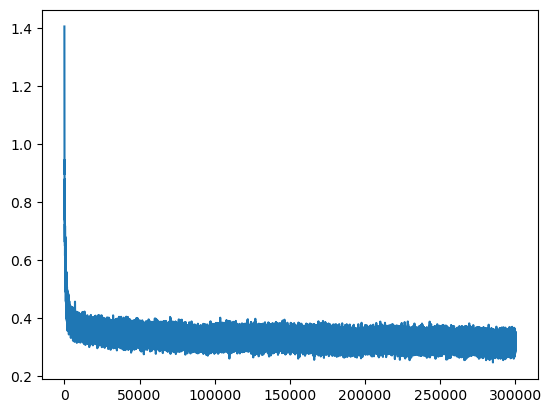

In [556]:
from statistics import fmean

BATCH_SIZE = 256 

for i in range(100_000):
    # Minibatch
    idx = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

    # Forward pass
    emb = C[Xtr[idx]]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[idx])

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 1e-1 if i <= 80_000 else 1e-2
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    # lri.append(lr[i])
    lossi.append(loss.log10().item())
    step += 1
    stepi.append(step)


print(fmean(lossi))
plt.plot(stepi, lossi)

In [557]:
with torch.no_grad():
    emb = C[Xdev]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print(loss.log10().item())


0.32771921157836914


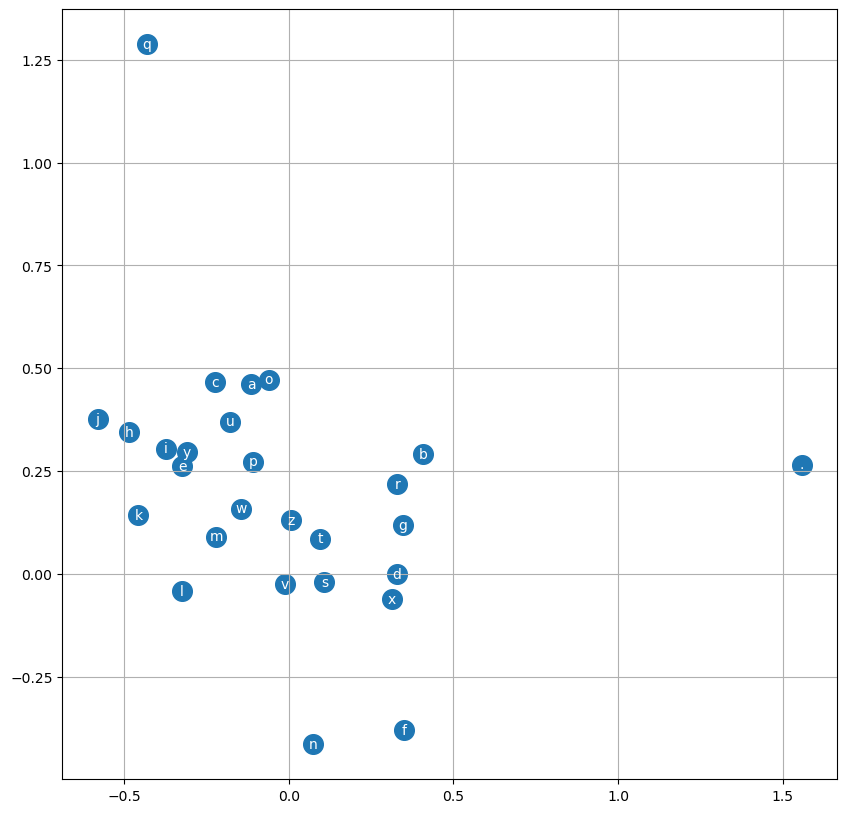

In [558]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itoc[i], ha='center', va='center', color='white')
plt.grid('minor')

In [560]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * CONTEXT_SIZE
    while True:
        with torch.no_grad():
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if idx == 0:
            break
        out.append(idx)
        context = context[1:] + [idx]
    print(''.join(itoc[o] for o in out))

carmahela
jharli
jarri
taty
skansh
emmahnen
den
arcilaqui
ner
kia
chaiir
kaleigh
ham
poim
quintis
lilea
jadis
waxtrosiearynix
kaellinsley
dae
